In [27]:
#!pip install tensorflow

In [28]:
import tensorflow as tf
from tensorflow import keras

In [29]:
#Creiamo un tf.data.Dataset a partire dalle immagini nella directory su disco per il training set e il test set.
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='int'
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels='inferred',
    label_mode='int'
)

Found 16932 files belonging to 4 classes.
Found 4233 files belonging to 4 classes.


In [30]:
#image_batch è un tensore della forma (32, 256, 256, 3) .
#Questo è un batch di 32 immagini di forma 256x256x3. 
#Il label_batch è un tensore della forma (32,4) cioè in ogni batch ci sono 32 immagini e le etichette sono 4
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


MobileNet deve ricevere come input immagini di dimensione (224,224,3), occorre dunque modificare la dimensione delle immagini. Inoltre i pixel devono assumere valori tra [-1, +1] e non da 0 a 255, occorre quindi anche eseguire una normalizzazione

In [31]:
#!pip install tensorflow --upgrade

In [32]:
from tensorflow.keras import layers

resize_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224, 224),
  layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)

])

def prepare(ds):
    #Resize
    ds = ds.map(lambda x, y: (resize_rescale(x),y))
    return ds

train_set = prepare(train_set)
test_set = prepare(test_set)


In [33]:
#Verifichiamo che sia avvenuto il resizing 
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


# TRANSFER LEARNING 

In [34]:
#Creiamo il modello base considerando MobileNet, sviluppato da Google e pre-addestrato su ImageNet.
#Non consideriamo gli ultimi layer che sono finalizzati agli obiettivi di classificazione di Imagenet
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')


In [35]:
#Il base_model si comporta quindi come un estrattore di featues,
#In particolare estrae dalle immagini 224x224x3 in blocchi 7x7x1280 di features. 
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [36]:
#Congeliamo il resto dei layer impedendone così l'aggiornamento durante l'addestramento.
base_model.trainable = False

In [37]:
#Ora a partire dal blocco di features, usiamo un layer tf.keras.layers.GlobalAveragePooling2D,
#facendo una media in una finestra 5x5, per generare le predizioni finali poichè ci consente di
#convertire le features in un singolo vettore di 1280 elementi per immagine.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [38]:
#Definiamo uno strato fully-connected per convertire queste features in una singola predizione.
prediction_layer = tf.keras.layers.Dense(4, activation='relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [39]:
#Costruiamo il modello considerando quanto definito precedentemente
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [40]:
#Compiliamo il modello
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
#Addestriamo il modello sul train set
history = model.fit(train_set, epochs=5)

Epoch 1/5
530/530 [==============================] - 534s 999ms/step - loss: 0.7588 - accuracy: 0.7206
Epoch 2/5
530/530 [==============================] - 530s 998ms/step - loss: 0.6528 - accuracy: 0.7695
Epoch 3/5
530/530 [==============================] - 531s 1s/step - loss: 0.6240 - accuracy: 0.7864
Epoch 4/5
530/530 [==============================] - 514s 968ms/step - loss: 0.6065 - accuracy: 0.7954
Epoch 5/5
530/530 [==============================] - 525s 989ms/step - loss: 0.5957 - accuracy: 0.8034


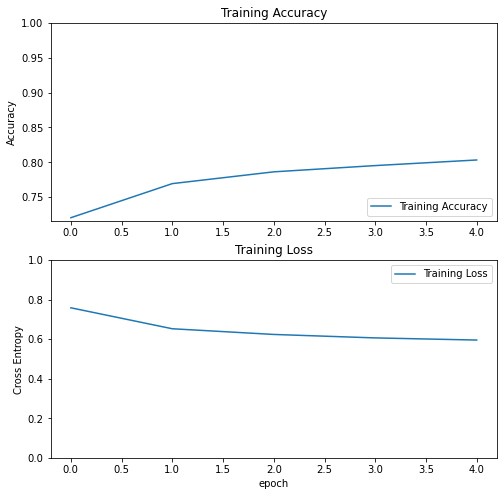

In [42]:
import matplotlib.pyplot as plt

#Analizziamo l'andamento dell'addestramento
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
#Valutiamo le prestazioni del modello sul test set
loss_test, accuracy_test = model.evaluate(test_set)
print('Test accuracy :', accuracy_test)

133/133 [==============================] - 132s 981ms/step - loss: 0.6537 - accuracy: 0.7808
Test accuracy : 0.7807701230049133


# FINE TUNING 

Un modo per incrementare le performance è eseguire fine-tuning, dove nel processo di training si 'aggiustano' i pesi degli ultimi layers così da specializzare la rete ancor di più al nostro dataset.

In [44]:
#'Scongeliamo' il base_model in modo da non addestrare solo i layer più in basso.
base_model.trainable = True

num_layers = len(base_model.layers)
num_layers

154

In [45]:
#Scegliamo di addestrare il modello solo a partire dal centesimo layer in su.
#quindi congeliamo tutti i layer precedenti.
finetune = 100
for layer in base_model.layers[:finetune]:
    layer.trainable =  False

In [46]:
#Ricompiliamo il modello.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 2,179,716
Non-trainable params: 83,392
_________________________________________________________________


In [47]:
#Continuiamo con l'addestramento.
finetune_epochs = 5
total_epochs =  5 + finetune_epochs

history_fine = model.fit(train_set, epochs=total_epochs, initial_epoch=history.epoch[-1])
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']

Epoch 5/10
530/530 [==============================] - 1042s 2s/step - loss: 1.4104 - accuracy: 0.1739
Epoch 6/10
530/530 [==============================] - 1066s 2s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 7/10
530/530 [==============================] - 1093s 2s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 8/10
530/530 [==============================] - 1094s 2s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 9/10
530/530 [==============================] - 1086s 2s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 10/10
530/530 [==============================] - 1078s 2s/step - loss: 1.3863 - accuracy: 0.1724


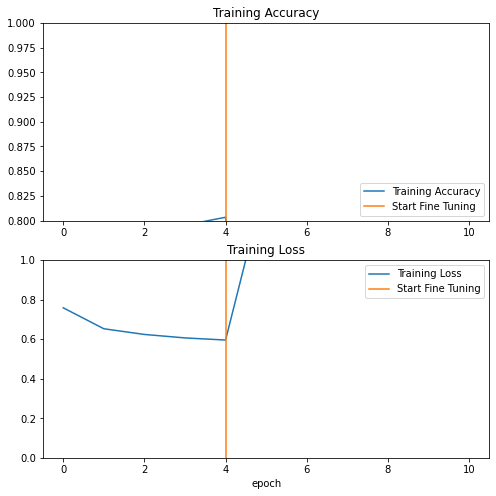

In [48]:
#Analizziamo l'andamento dell'addestramento.
initial_epochs = 5
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')

plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()


In [49]:
#Valutazione del modello sul test set.
loss_test, accuracy_test = model.evaluate(test_set)
print('Test accuracy :', accuracy_test)

133/133 [==============================] - 140s 1s/step - loss: 1.3863 - accuracy: 0.1647
Test accuracy : 0.16465863585472107
